## Setup

First, let's install our required packages and set our OpenAI API key (the LLM we will use)

In [1]:

! pip install -U langgraph langchain_openai

In [1]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

# OpenAI-4o with image

In [34]:
from typing import List

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI

from pydantic import BaseModel

In [35]:
import base64
from pathlib import Path

image_path = Path("langchain_casestudy/1.2.840.114158.56704955333066712427027635011666661305.jpg")
with open(image_path, "rb") as img_file:
    image_data = base64.b64encode(img_file.read()).decode('utf-8')


In [36]:
message = HumanMessage(
    content=[
        {"type": "text", "text": "describe the image"},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
    ],
)
#llm = ChatOpenAI(model="gpt-4o",temperature=0)
#response = llm.invoke([message])
#print(response.content)

# Graph build

In [2]:
from typing import Annotated
from langchain_core.messages import BaseMessage
from langchain_core.messages import SystemMessage
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool
import base64
from pathlib import Path
import json
from langchain_core.messages import ToolMessage, HumanMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

@tool
def nodule_detection() -> None:
    """Detect nodules in the CT scan."""
    image_path = Path("langchain_casestudy/1.2.840.114158.56704955333066712427027635011666661305_bbox.jpg")
    with open(image_path, "rb") as img_file:
        image_data = base64.b64encode(img_file.read()).decode('utf-8')
    content=[
        {"type": "text", "text": "The suspect nodules are marked as red bounding box in the image. Does the suspect nodule look like a nodule? Options: Yes, No"},
        {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_data}"}},
    ]
    return content

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                 ToolMessage(
                    content="Tool response is included in the next message as a Human message . Please describe the nodule",
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        humanmessage = HumanMessage(content = tool_result)
        outputs.append(humanmessage)
        return {"messages": outputs}

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END

class BasicVQANode:
    """A node that asks the VQA questions."""
    def __init__(self, index) -> None:
        self.question_list = [
            "What is the size of the detected nodule? Options: <=4mm, 4~6mm, 6~8mm, 8~15mm, 15~30mm, >30mm",
            "Where is the detected nodule in the lung field? Options: right upper lobe, left upper lobe, right middle lobe, right lower lobe, left lower lobe, lingula",
            "What is the density of the detected nodule in the lung? Options: part solid, non solid, solid, calcified",
            "What is the margin or shape of the detected nodule? Options: smooth, lentiform, triangular, spikes, lobules, irregular, indistinct, unable to determine",
            "What is the characteristic of the detected nodule? Options: fat-containing, inflammatory, air bronchograms, unable to determine"
        ]
        self.index = index

    def __call__(self, inputs: dict):
        outputs = []
        for question in self.question_list:
            question = "The suspect nodules are marked as red bounding box in the image. Question : " + question
            image_path = Path("langchain_casestudy/1.2.840.114158.56704955333066712427027635011666661305_bbox.jpg")
            with open(image_path, "rb") as img_file:
                image_data = base64.b64encode(img_file.read()).decode('utf-8')
            content=[
                {"type": "text", "text": question},
                {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{image_data}"}},
            ]
            message = HumanMessage(content=content)
            outputs.append(message)
            response = llm.invoke([message])
            outputs.append(response)
        summary_question = "Summarize nodule attributes based on the answers above"
        final_msg = HumanMessage(content = summary_question)
        outputs.append(final_msg)
        return {"messages": outputs}

def route_vqa(
    state: State,
):
    """
    Use in the conditional_edge to route to the VQA. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if "yes" in ai_message.content.lower():
        return "VQA"
    return END

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tools = [nodule_detection]
llm = ChatOpenAI(model="gpt-4o",temperature=0)
llm_with_tools = llm.bind_tools(tools)

template = """You are a medical AI visual assistant that can analyze a single CT image. 
You can see the image and you need to describe the image in detail or answering question.
You can also detect nodules in the CT scan by using detection tools.
"""


def get_messages_info(messages):
    return [SystemMessage(content=template)] + messages
def chatbot(state: State):
    messages = get_messages_info(state["messages"])
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


graph_builder.add_node("chatbot", chatbot)

tool_node = BasicToolNode(tools=[nodule_detection])
graph_builder.add_node("tools", tool_node)
vqa_node = BasicVQANode(index=0)
graph_builder.add_node("VQA", vqa_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    {"tools": "tools", END: END},
)
graph_builder.add_conditional_edges(
    "chatbot",
    route_vqa,
    {"VQA": "VQA", END: END},
)
graph_builder.add_edge("VQA", "chatbot")
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile()

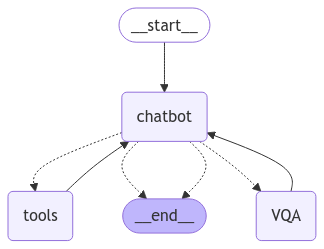

In [3]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Run Graph

Assistant: 
Assistant: [{'type': 'text', 'text': 'The suspect nodules are marked as red bounding box in the image. Does the suspect nodule look like a nodule? Options: Yes, No'}, {'type': 'image_url', 'image_url': {'url': ''}}]
Assistant: Yes, the suspect nodule marked in the red bounding box looks like a nodule.
Assistant: Summarize nodule attributes based on the answers above
Assistant: Based on the answers provided:

- **Appearance**: The suspect nodule looks like a nodule.
- **Size**: <=4mm.
- **Location**: Right upper lobe.
- **Density**: Unable to determine.
- **Margin/Shape**: Unable to determine.
- **Characteristic**: Unable to determine.

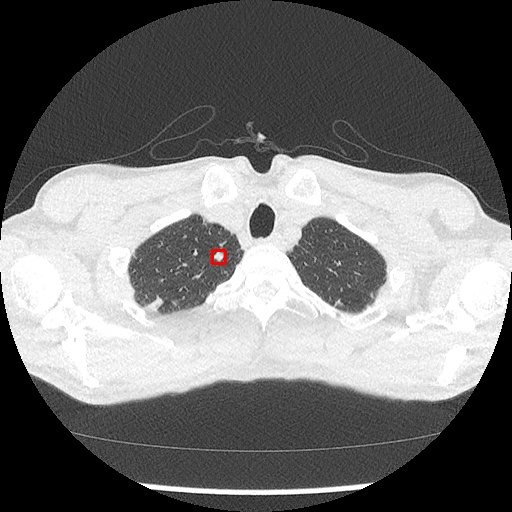

In [4]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
'''
while True:
    try:
        user_input = input("User: ")
        print("User: " + user_input)
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break
'''
import base64
from pathlib import Path

image_path = Path("langchain_casestudy/1.2.840.114158.56704955333066712427027635011666661305.jpg")
with open(image_path, "rb") as img_file:
    image_data = base64.b64encode(img_file.read()).decode('utf-8')
user_input = "Detect the nodules in the CT image"
message = HumanMessage(
    content=[
        {"type": "text", "text": user_input},
        {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},
        },
    ],
)
stream_graph_updates(user_input)